# Contextual Retrieval for Multimodal RAG with Azure AI Search, Azure OpenAI, Arize Phoenix, LlamaParse and LlamaIndex

[Farzad S.](https://www.linkedin.com/in/farzadsunavala/)

## Introduction
In this notebook, we'll demonstrate how to build a contextual retrieval multimodal Retrieval-Augmented Generation (RAG) pipeline using Azure AI Search and Azure OpenAI in LlamaIndex.

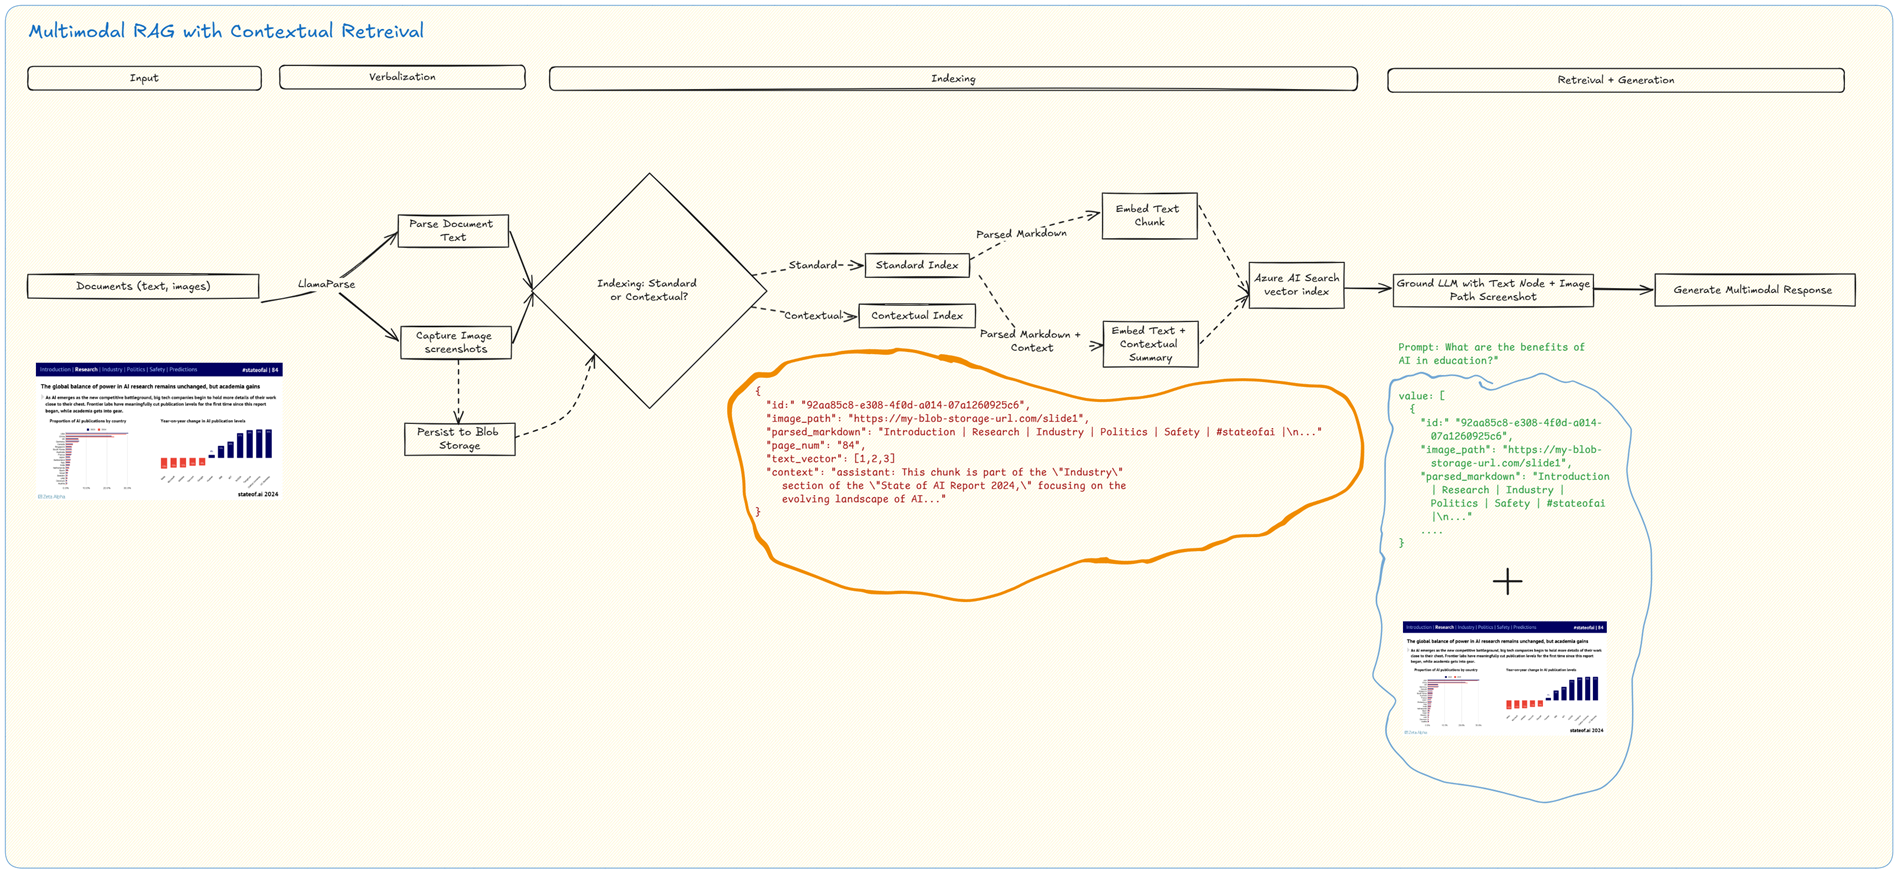

## Steps Overview:
1. **Setup**: Install necessary packages and set up credentials.
2. **Load and Parse Document**: Download and parse a Microsoft PowerPoint (PPTX) file into text and images using markdown parsing and LLM verbalization.
3. **Create Text Nodes with Contextual Metadata**: Generate contextual summaries for each text chunk.
4. **Map Metadata to Azure AI Search Schema**: Define how metadata fields correspond to Azure AI Search fields.
5. **Initialize Azure AI Search Vector Store**: Set up the vector store with the appropriate multimodal schema.
6. **Index Documents into Azure AI Search**: Index the text nodes with metadata into Azure AI Search.
7. **Build Multimodal Query Engine**: Create a query engine that can handle text and images.
8. **Perform Queries**: Execute queries and observe how contextual retrieval improves results.
9. **Evaluate Query Engines**: Evaluate using Arize Phoenix Evaluators to compare different topK chunk sizes and query engine modes.

This notebook is suitable for beginners and provides detailed explanations throughout.

## Prerequisites
- **Azure Sub** with access to Azure AI Search and Azure OpenAI services.
- **LlamaCloud** key for LlamaParse.
- **API keys and endpoints** for both services.
- Python environment with necessary packages installed.

## Setup
### Install Required Packages
First, install the required Python packages.

In [ ]:
# Install necessary packages
# !pip install llama-index
# !pip install wget
# !pip install llama-index-vector-stores-azureaisearch
# !pip install azure-search-documents 
# !pip install llama-index-embeddings-azure-openai
# !pip install llama-index-llms-azure-openai
# !pip install llama-index-multi-modal-llms-azure-openai
# !pip install openai
# !pip install nest_asyncio
# !pip install arize-phoenix


In [ ]:
# Display the version of each installed package
!pip show llama-index | findstr Version
!pip show wget | findstr Version
!pip show llama-index-vector-stores-azureaisearch | findstr Version
!pip show azure-search-documents | findstr Version
!pip show llama-index-embeddings-azure-openai | findstr Version
!pip show llama-index-llms-azure-openai | findstr Version
!pip show llama-index-multi-modal-llms-azure-openai | findstr Version
!pip show openai | findstr Version
!pip show nest_asyncio | findstr Version

### Import Libraries
Import all the necessary libraries to begin.

In [5]:
# Initial Setup: Load environment variables and initialize services
import os
import json
import time
import logging
from copy import deepcopy
from dotenv import load_dotenv
import nest_asyncio
from typing import Optional

from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient

from llama_index.core import StorageContext, VectorStoreIndex, SimpleDirectoryReader
from llama_index.core.schema import TextNode, ImageNode, NodeWithScore, MetadataMode
from llama_index.core.settings import Settings
from llama_index.core.query_engine import CustomQueryEngine, SimpleMultiModalQueryEngine
from llama_index.core.retrievers import BaseRetriever
from llama_index.core.prompts import PromptTemplate
from llama_index.core.base.response.schema import Response
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.vector_stores.azureaisearch import AzureAISearchVectorStore, IndexManagement, MetadataIndexFieldType


# Apply nest_asyncio to avoid asyncio errors in notebooks
nest_asyncio.apply()

### Set Up Azure Credentials
Replace placeholders with your Azure credentials.

In [20]:
# Environment Variables
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME = os.getenv("AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME")
AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME = os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME")
SEARCH_SERVICE_ENDPOINT = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
SEARCH_SERVICE_API_KEY = os.getenv("AZURE_SEARCH_ADMIN_KEY")
INDEX_NAME = "llamaindex-multimodal-contextual-retreival"

### Initialize LLM and Embedding Models and Azure AI Search client


In [21]:
# Initialize Azure OpenAI models
llm = AzureOpenAI(
    model=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    deployment_name=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version="2024-06-01"
)

embed_model = AzureOpenAIEmbedding(
    model=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME,
    deployment_name=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version="2024-06-01"
)

Settings.llm = llm
Settings.embed_model = embed_model

# Initialize search clients
credential = AzureKeyCredential(SEARCH_SERVICE_API_KEY)
index_client = SearchIndexClient(endpoint=SEARCH_SERVICE_ENDPOINT, credential=credential)
search_client = SearchClient(endpoint=SEARCH_SERVICE_ENDPOINT, index_name=INDEX_NAME, credential=credential)


### Setup Observability with Arize Phoenix 

In [22]:
# Phoenix can display in real time the traces automatically
# collected from your LlamaIndex application.
# Run all of your LlamaIndex applications as usual and traces
# will be collected and displayed in Phoenix.

import phoenix as px

# Look for a URL in the output to open the App in a browser.
px.launch_app()
# The App is initially empty, but as you proceed with the steps below,
# traces will appear automatically as your LlamaIndex application runs.

import llama_index.core

llama_index.core.set_global_handler("arize_phoenix")
...

🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


Ellipsis

## Load and Parse the Document
### Download the State of AI 2024 Report
We'll use the State of AI Report October 2024
[STATE OF THE AI OCTOBER 2024 REPORT](https://docs.google.com/presentation/d/1GmZmoWOa2O92BPrncRcTKa15xvQGhq7g4I4hJSNlC0M/edit).

Or, you can download the slide deck and just put in a folder path locally (note, the file is large so add it to your .gitignore)

In [ ]:
import os
import requests

# Create directories to store data
os.makedirs('data', exist_ok=True)
os.makedirs('data_images_state_of_ai_2024', exist_ok=True)

# Google Slides export link
export_link = "https://docs.google.com/presentation/d/1GmZmoWOa2O92BPrncRcTKa15xvQGhq7g4I4hJSNlC0M/export/pptx"

# Download the PPT report
response = requests.get(export_link)
with open('data/pptx/state-of-ai.pptx', 'wb') as file:
    file.write(response.content)

### Parse the Document Using LlamaParse
We'll parse the PDF into text and images using `LlamaParse`. Note that using `LlamaParse` with premium mode may incur costs.

In [ ]:
from llama_parse import LlamaParse

# Initialize LlamaParse
parser = LlamaParse(
    result_type="markdown",
    premium_mode=True
)

# Parse the PDF document
print(f"Parsing text...")
md_json_objs = parser.get_json_result("data/pptx/state-of-ai.pptx")
md_json_list = md_json_objs[0]["pages"]

# Optionally, extract images
image_dicts = parser.get_images(md_json_objs, download_path="data_images_state_of_ai_report_2024")

In [ ]:
print(md_json_list[10]["md"])

## Build Multimodal Index
We will build a multimodal index over the parsed document by creating text nodes that contain metadata referencing the original image paths.

### Get Text Nodes
We'll create TextNode objects from the parsed markdown data, attaching metadata such as page numbers and image paths.

In [ ]:
import re
from copy import deepcopy
from pathlib import Path

def get_page_number(file_name):
    match = re.search(r"-page_(\d+)\.jpg$", str(file_name))
    if match:
        return int(match.group(1))
    return 0

def _get_sorted_image_files(image_dir):
    """Get image files sorted by page."""
    raw_files = [
        f for f in list(Path(image_dir).iterdir()) if f.is_file() and "-page" in str(f)
    ]
    sorted_files = sorted(raw_files, key=get_page_number)
    return sorted_files

# Attach image metadata to the text nodes
def get_text_nodes(image_dir, json_dicts):
    """Create TextNodes with metadata including image paths and doc_id."""
    nodes = []

    image_files = _get_sorted_image_files(image_dir)
    md_texts = [d["md"] for d in json_dicts]

    for idx, md_text in enumerate(md_texts):
        # Assign a unique doc_id for each text node
        doc_id = f"doc_{idx+1}"  # Can be a string or an integer

        # Add doc_id to the metadata
        chunk_metadata = {
            "page_num": idx + 1,
            "image_path": str(image_files[idx]),
            "parsed_text_markdown": md_texts[idx],
        }

        node = TextNode(
            text="",
            metadata=chunk_metadata,
        )
        nodes.append(node)

    return nodes


# Create text nodes
text_nodes = get_text_nodes(image_dir="data_images_state_of_ai_report_2024", json_dicts=md_json_list)

# Print an example node
print(text_nodes[0].get_content(metadata_mode="all"))


### Add Contextual Summaries
We implement the key step in contextual retrieval by attaching metadata to each chunk that situates it within the overall document context.

In [ ]:
from llama_index.core.schema import MetadataMode
from copy import deepcopy
from llama_index.core.llms import ChatMessage
import time

# Prepare prompts for contextual summaries
whole_doc_text = """\
Here is the entire document.
<document>
{WHOLE_DOCUMENT}
</document>"""

chunk_text = """\
Here is the chunk we want to situate within the whole document
<chunk>
{CHUNK_CONTENT}
</chunk>
Please give a short succinct context to situate this chunk within the overall document for \
the purposes of improving search retrieval of the chunk. Answer only with the succinct context and nothing else."""

# Modify the function that creates contextual nodes so that they are well incorporated in embedding
def create_contextual_nodes(nodes, llm):
    """Function to create contextual nodes with added context."""
    nodes_modified = []

    # Get overall document text
    doc_text = "\n".join([n.get_content(metadata_mode=MetadataMode.ALL) for n in nodes])

    for idx, node in enumerate(nodes):
        start_time = time.time()
        new_node = deepcopy(node)

        # Messages to generate contextual summary
        messages = [
            ChatMessage(role="system", content="You are a helpful AI Assistant."),
            ChatMessage(
                role="user",
                content=[
                    {
                        "text": whole_doc_text.format(WHOLE_DOCUMENT=doc_text),
                        "type": "text",
                        "cache_control": {"type": "ephemeral"},
                    },
                    {
                        "text": chunk_text.format(
                            CHUNK_CONTENT=node.get_content(metadata_mode=MetadataMode.ALL)
                        ),
                        "type": "text",
                    },
                ],
            ),
        ]

        # Generate contextual summary
        new_response = llm.chat(messages)
        new_node.metadata["context"] = str(new_response)

        nodes_modified.append(new_node)
        print(f"Completed node {idx}, {time.time() - start_time}")

    return nodes_modified

# Create contextual text nodes with context incorporated
new_text_nodes = create_contextual_nodes(text_nodes, llm)

# Print to verify that context is included in metadata
print(new_text_nodes[0].metadata)

In [ ]:
new_text_nodes[0]

## Build Index with Azure AI Search
We will now build two indexes with Azure AI Search. The first will be our Contextual Summary index and the other will be a Standard (Baseline) index to compare later.
### Index contextual summary nodes 

In [23]:
# --- Indexing Part (modified to bypass LlamaIndex Documents) ---

# Define metadata fields mapping
metadata_fields = {
    "page_num": ("page_num", MetadataIndexFieldType.INT64),
    "image_path": ("image_path", MetadataIndexFieldType.STRING),
    "parsed_text_markdown": ("parsed_text_markdown", MetadataIndexFieldType.STRING),
    "context": (
        "context",
        MetadataIndexFieldType.STRING,
    ),  # Only used for contextual index
}

# --- Contextual Retrieval Index ---

# Set this to True if you want to use an existing index, False to create a new one
use_existing_index = True

# Create the Azure AI Search vector store for contextual retrieval
if use_existing_index:
    contextual_vector_store = AzureAISearchVectorStore(
        search_or_index_client=index_client,
        index_name="llamaindex-multimodal-contextual-retrieval",
        index_management=IndexManagement.VALIDATE_INDEX,
        id_field_key="id",
        chunk_field_key="parsed_text_markdown",
        embedding_field_key="embedding",
        embedding_dimensionality=1536,  # Based on embedding model
        metadata_string_field_key="metadata",
        doc_id_field_key="doc_id",
        filterable_metadata_field_keys=metadata_fields,
        language_analyzer="en.lucene",
        vector_algorithm_type="exhaustiveKnn",
    )
else:
    contextual_vector_store = AzureAISearchVectorStore(
        search_or_index_client=index_client,
        index_name="llamaindex-multimodal-contextual-retrieval",
        index_management=IndexManagement.CREATE_IF_NOT_EXISTS,
        id_field_key="id",
        chunk_field_key="parsed_text_markdown",
        embedding_field_key="embedding",
        embedding_dimensionality=1536,  # Based on embedding model
        metadata_string_field_key="metadata",
        doc_id_field_key="doc_id",
        filterable_metadata_field_keys=metadata_fields,
        language_analyzer="en.lucene",
        vector_algorithm_type="exhaustiveKnn",
    )

# Load documents and create index based on the use_existing_index flag
if use_existing_index:
    contextual_storage_context = StorageContext.from_defaults(
        vector_store=contextual_vector_store
    )
    contextual_index = VectorStoreIndex.from_documents(
        [],
        storage_context=contextual_storage_context,
    )

else:
    # Load documents
    contextual_storage_context = StorageContext.from_defaults(
        vector_store=contextual_vector_store
    )

    # Create index using `new_text_nodes` directly
    contextual_index = VectorStoreIndex(
        new_text_nodes,  # Use the text nodes with contextual embeddings
        storage_context=contextual_storage_context,
        embed_model=embed_model,
        llm=llm,
        show_progress=True,
    )

Subtype value aml has no mapping, use base class VectorSearchVectorizer.
Subtype value aml has no mapping, use base class VectorSearchVectorizer.
Subtype value aml has no mapping, use base class VectorSearchVectorizer.


### Build Baseline Index
We will also build a baseline index with the text nodes without contextual summaries for comparison.

In [24]:
# Define metadata fields mapping
metadata_fields = {
    "page_num": ("page_num", MetadataIndexFieldType.INT64),
    "image_path": ("image_path", MetadataIndexFieldType.STRING),
    "parsed_text_markdown": ("parsed_text_markdown", MetadataIndexFieldType.STRING),
}

# --- Baseline Index ---

# Set this to True if you want to use an existing index, False to create a new one
use_existing_index = True

# Create the Azure AI Search vector store for baseline retrieval
if use_existing_index:
    baseline_vector_store = AzureAISearchVectorStore(
        search_or_index_client=index_client,
        index_name="llamaindex-multimodal-standard",
        index_management=IndexManagement.VALIDATE_INDEX,
        id_field_key="id",
        chunk_field_key="parsed_text_markdown",
        embedding_field_key="embedding",
        embedding_dimensionality=1536,
        metadata_string_field_key="metadata",
        doc_id_field_key="doc_id",
        filterable_metadata_field_keys=metadata_fields,
        language_analyzer="en.lucene",
        vector_algorithm_type="exhaustiveKnn",
    )
else:
    baseline_vector_store = AzureAISearchVectorStore(
        search_or_index_client=index_client,
        index_name="llamaindex-multimodal-standard",
        index_management=IndexManagement.CREATE_IF_NOT_EXISTS,
        id_field_key="id",
        chunk_field_key="parsed_text_markdown",
        embedding_field_key="embedding",
        embedding_dimensionality=1536,
        metadata_string_field_key="metadata",
        doc_id_field_key="doc_id",
        filterable_metadata_field_keys=metadata_fields,
        language_analyzer="en.lucene",
        vector_algorithm_type="exhaustiveKnn",
    )

# Load documents and create index based on the use_existing_index flag
if use_existing_index:
    baseline_storage_context = StorageContext.from_defaults(vector_store=baseline_vector_store)
    baseline_index = VectorStoreIndex.from_documents(
        [],
        storage_context=baseline_storage_context,
    )
else:
    # Load documents
    baseline_storage_context = StorageContext.from_defaults(vector_store=baseline_vector_store)

    # Create index
    baseline_index = VectorStoreIndex(
        nodes=text_nodes,
        storage_context=baseline_storage_context,
        embed_model=embed_model,
        llm=llm,
        show_progress=True,
    )

Subtype value aml has no mapping, use base class VectorSearchVectorizer.
Subtype value aml has no mapping, use base class VectorSearchVectorizer.
Subtype value aml has no mapping, use base class VectorSearchVectorizer.


## Build Multimodal Query Engine
### Create a custom multimodal query engine using Azure OpenAI GPT-4o-mini
We will build a custom multimodal query engine that can retrieve both text and image data.

In [25]:
from llama_index.core.query_engine import CustomQueryEngine, BaseQueryEngine
from llama_index.core.retrievers import BaseRetriever
from llama_index.multi_modal_llms.azure_openai import AzureOpenAIMultiModal
from llama_index.core.schema import ImageNode, NodeWithScore, MetadataMode
from llama_index.core.prompts import PromptTemplate
from llama_index.core.base.response.schema import Response
from typing import Optional

# Initialize AzureOpenAIMultiModal for GPT-4o-mini
azure_openai_mm_llm = AzureOpenAIMultiModal(
    engine="gpt-4o-mini",  # Use GPT-4o-mini
    api_version="2024-06-01",
    model="gpt-4o-mini",
    max_new_tokens=4096,
    api_key=AZURE_OPENAI_API_KEY,
    api_base=AZURE_OPENAI_ENDPOINT,
)

QA_PROMPT_TMPL = """\
Below we give parsed text from slides in parsed markdown format, as well as the image.

---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query. Explain whether you got the answer
from the parsed markdown or raw text or image, and if there's discrepancies, and your reasoning for the final answer.

Query: {query_str}
Answer: """

QA_PROMPT = PromptTemplate(QA_PROMPT_TMPL)


class MultimodalQueryEngine(CustomQueryEngine):
    """Custom multimodal Query Engine.

    Takes in a retriever to retrieve a set of document nodes.
    Also takes in a prompt template and multimodal model.

    """

    qa_prompt: PromptTemplate
    retriever: BaseRetriever
    multi_modal_llm: AzureOpenAIMultiModal

    def __init__(self, qa_prompt: Optional[PromptTemplate] = None, **kwargs) -> None:
        """Initialize."""
        super().__init__(qa_prompt=qa_prompt or QA_PROMPT, **kwargs)

    def custom_query(self, query_str: str):
        # retrieve text nodes
        nodes = self.retriever.retrieve(query_str)
        # create ImageNode items from text nodes
        image_nodes = [
            NodeWithScore(node=ImageNode(image_path=n.metadata["image_path"]))
            for n in nodes
        ]

        # create context string from text nodes, dump into the prompt
        context_str = "\n\n".join(
            [r.get_content(metadata_mode=MetadataMode.LLM) for r in nodes]
        )
        fmt_prompt = self.qa_prompt.format(context_str=context_str, query_str=query_str)

        # synthesize an answer from formatted text and images
        llm_response = self.multi_modal_llm.complete(
            prompt=fmt_prompt,
            image_documents=[image_node.node for image_node in image_nodes],
        )
        return Response(
            response=str(llm_response),
            source_nodes=nodes,
            metadata={"text_nodes": nodes, "image_nodes": image_nodes},
        )

        return response

### Build different query engines for evaluation
In this step, we'll build 6 different query engines to evaluate different configurations similar to the [Anthropic Contextual Retreival Blog](https://www.anthropic.com/news/contextual-retrieval)

In [27]:
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.vector_stores.types import VectorStoreQueryMode
from llama_index.core import get_response_synthesizer
import pprint

# define response synthesizer
response_synthesizer = get_response_synthesizer()

# Standard Query Engines (Standard Retrieval)
standard_embedding_query_engine = MultimodalQueryEngine(
    retriever=baseline_index.as_retriever(vector_store_query_mode=VectorStoreQueryMode.DEFAULT, similarity_top_k=20),
    multi_modal_llm=azure_openai_mm_llm,
)

standard_hybrid_query_engine = MultimodalQueryEngine(
    retriever=baseline_index.as_retriever(vector_store_query_mode=VectorStoreQueryMode.HYBRID, similarity_top_k=20),
    multi_modal_llm=azure_openai_mm_llm,
)

standard_semantic_hybrid_query_engine = MultimodalQueryEngine(
    retriever=baseline_index.as_retriever(vector_store_query_mode=VectorStoreQueryMode.SEMANTIC_HYBRID, similarity_top_k=20),
    multi_modal_llm=azure_openai_mm_llm,
)

# Contextual Query Engines (Contextual Retrieval)
contextual_embedding_query_engine = MultimodalQueryEngine(
    retriever=contextual_index.as_retriever(vector_store_query_mode=VectorStoreQueryMode.DEFAULT, similarity_top_k=20),
    multi_modal_llm=azure_openai_mm_llm,
)

contextual_hybrid_query_engine = MultimodalQueryEngine(
    retriever=contextual_index.as_retriever(vector_store_query_mode=VectorStoreQueryMode.HYBRID, similarity_top_k=20),
    multi_modal_llm=azure_openai_mm_llm,
)

contextual_semantic_hybrid_query_engine = MultimodalQueryEngine(
    retriever=contextual_index.as_retriever(vector_store_query_mode=VectorStoreQueryMode.SEMANTIC_HYBRID, similarity_top_k=20),
    multi_modal_llm=azure_openai_mm_llm,
)

## Perform Queries
Let's test our multimodal RAG pipeline by asking some questions.
### Query Example 1

Query: What trends in AI compute efficiency were identified in 2024, and how does the performance of inference compute compare to previous years?
Retrieved Images:



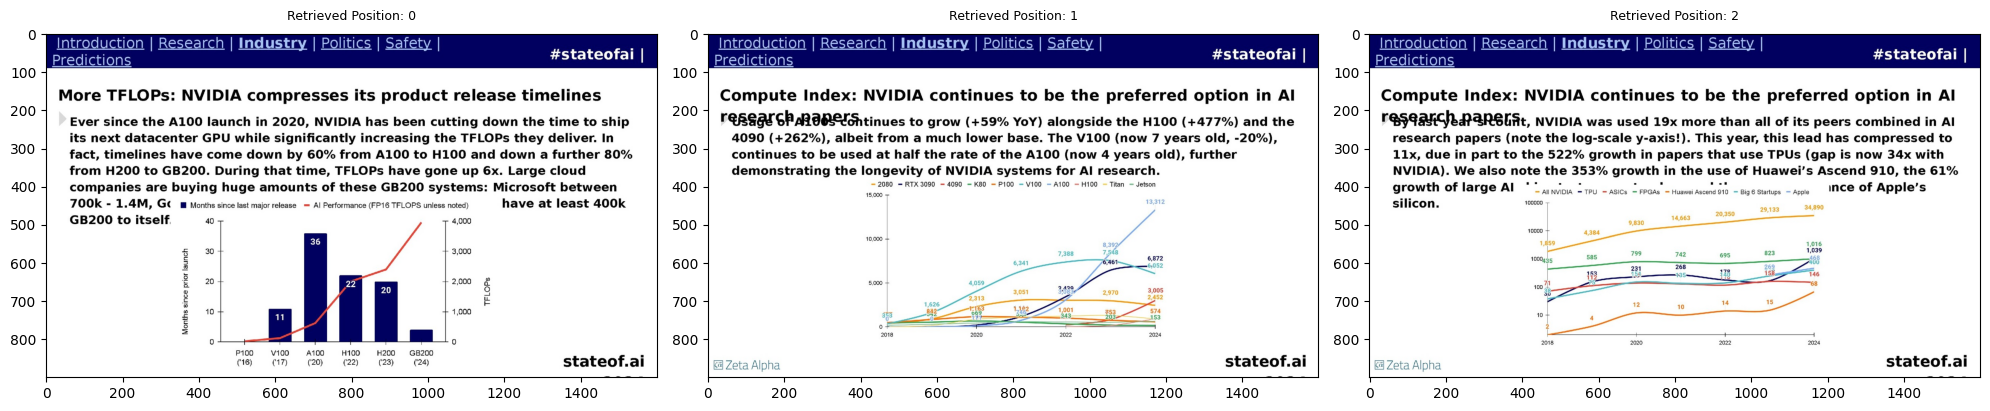

Response: The trends in AI compute efficiency identified in 2024 highlight significant advancements in NVIDIA's GPU performance and usage in AI research. Key points include:

1. **Increased TFLOPs**: NVIDIA has significantly increased the performance of its GPUs, with the GB200 model expected to deliver around 4000 FP16 TFLOPS, a substantial increase from previous models. This represents a 6x increase in TFLOPs from the A100 to the GB200.

2. **Reduced Release Timelines**: The time between major GPU releases has decreased dramatically, with timelines cut by 60% from the A100 to the H100 and by an additional 80% from the H200 to the GB200.

3. **Growing Adoption**: The usage of NVIDIA GPUs in AI research papers continues to grow, with the A100 seeing a 59% year-over-year increase, the H100 at 477%, and the 4090 at 262%. This indicates a strong preference for NVIDIA products in the AI research community.

4. **Comparative Performance**: The V100, despite being 7 years old, is still used 

In [14]:
from llama_index.core.response.notebook_utils import display_response, display_query_and_multimodal_response, display_source_node
from llama_index.core.schema import MetadataMode
from openinference.instrumentation import using_metadata


# Query with baseline retrieval
query = "What trends in AI compute efficiency were identified in 2024, and how does the performance of inference compute compare to previous years?"
baseline_response = standard_embedding_query_engine.query(query)

with using_metadata({"engine": "standard_embedding_query_engine"}):
    result_b = standard_embedding_query_engine.query(query)
    display_query_and_multimodal_response(query, result_b, 8, 20)
    print("\nSource Nodes for standard_embedding_query_engine:")
    for node in result_b.source_nodes:
        print(node.get_content(metadata_mode=MetadataMode.LLM))

### Query Example 2

Query: What trends in AI compute efficiency were identified in 2024, and how does the performance of inference compute compare to previous years?
Retrieved Images:



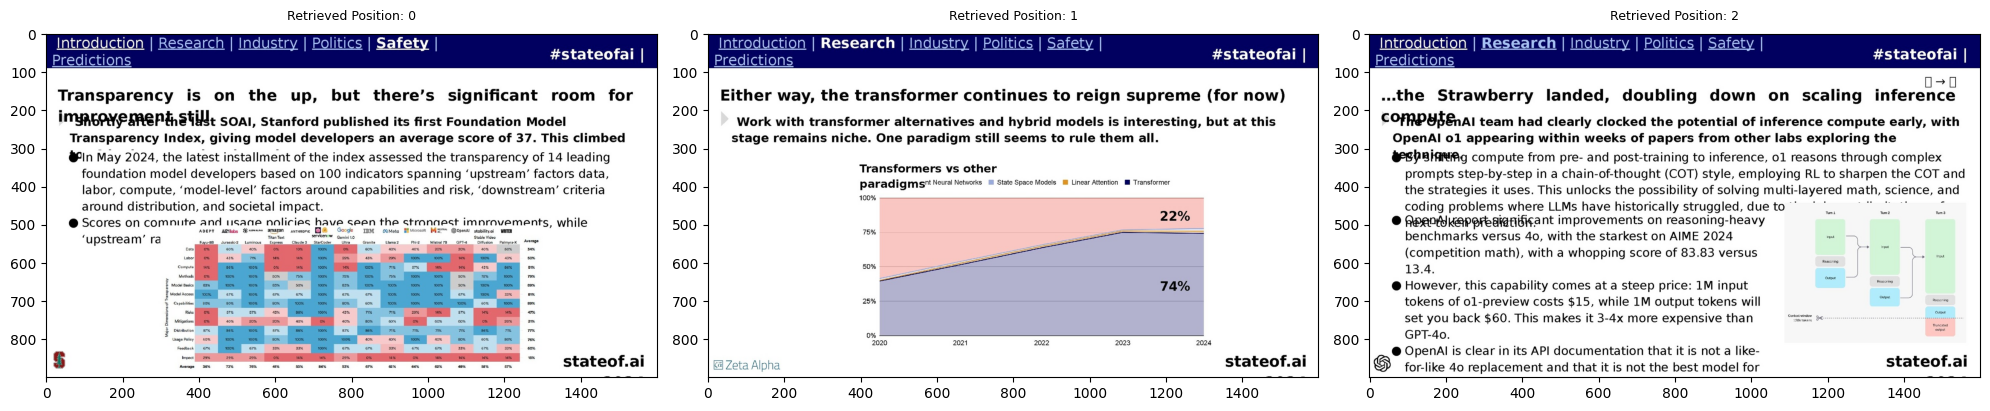

Response: The trends in AI compute efficiency identified in 2024 highlight a significant focus on inference compute, particularly with OpenAI's o1 model. This model shifts compute from pre- and post-training to inference, allowing for improved reasoning through complex prompts in a chain-of-thought (COT) style. The performance on reasoning-heavy benchmarks has shown substantial improvements, with OpenAI reporting a score of 83.83 on AIME 2024 compared to 13.4 for the previous model (4o).

In terms of overall trends, the parsed markdown indicates that while there is interesting work with transformer alternatives and hybrid models, transformers continue to dominate the field, holding a 74% share in 2024. This suggests that while there are advancements in compute efficiency, particularly with inference, the transformer architecture remains the prevailing paradigm.

The answer is derived from the parsed markdown, specifically from the section discussing OpenAI's advancements with the o1 mo

In [15]:
from llama_index.core.response.notebook_utils import display_query_and_multimodal_response
from llama_index.core.schema import MetadataMode
import os

# Query with contextual retrieval
query = "What trends in AI compute efficiency were identified in 2024, and how does the performance of inference compute compare to previous years?"
contextual_response = contextual_semantic_hybrid_query_engine.query(query)
with using_metadata({"engine": "contextual_semantic_hybrid_query_engine"}):
    result_a = contextual_semantic_hybrid_query_engine.query(query)
    display_query_and_multimodal_response(query, result_a, 8, 20)
    print("\nSource Nodes for contextual_semantic_hybrid_query_engine:")
    for node in result_a.source_nodes:
        print(node.get_content(metadata_mode=MetadataMode.LLM))

In [16]:
def get_source_page_nums(response):
    page_nums = [str(node.node.metadata.get("page_num", "N/A")) for node in response.source_nodes]
    print(",".join(page_nums))

# Compare source page numbers
print("Pages retrieved with standard retreival:")
get_source_page_nums(baseline_response)

print("Pages retrieved with contextual retrieval:")
get_source_page_nums(contextual_response)

Pages retrieved with standard retreival:
96,94,93
Pages retrieved with contextual retrieval:
195,28,13


### Query Example 3

Query: What are the current capabilities and limitations of OpenAI's o1 model in solving complex mathematical problems?
Retrieved Images:



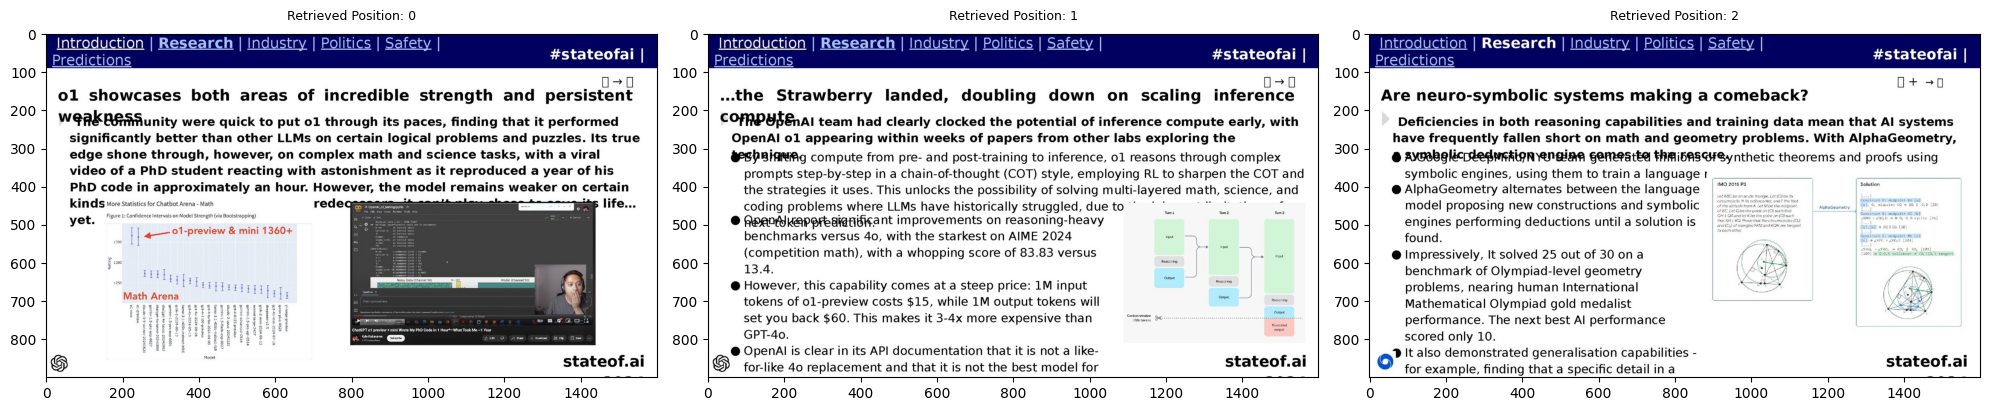

Response: The current capabilities and limitations of OpenAI's o1 model in solving complex mathematical problems are as follows:

### Capabilities:
1. **Strength in Reasoning**: The o1 model performs significantly better than other large language models (LLMs) on logical problems and complex math tasks.
2. **Chain-of-Thought (COT) Reasoning**: It employs a step-by-step reasoning approach, which allows it to tackle multi-layered math, science, and coding problems effectively.
3. **High Performance on Benchmarks**: The model has shown significant improvements on reasoning-heavy benchmarks, achieving a score of 83.83 on AIME 2024 (competition math), compared to a much lower score of 13.4 from its predecessor.

### Limitations:
1. **Weakness in Spatial Reasoning**: The model struggles with certain types of spatial reasoning tasks, such as playing chess.
2. **Cost of Usage**: The operational cost is high, with 1 million input tokens costing $15 and 1 million output tokens costing $60, makin

In [17]:
from llama_index.core.response.notebook_utils import display_response, display_query_and_multimodal_response, display_source_node
from llama_index.core.schema import MetadataMode

# Query with baseline retrieval
query = "What are the current capabilities and limitations of OpenAI's o1 model in solving complex mathematical problems?"
baseline_response = standard_embedding_query_engine.query(query)

with using_metadata({"engine": "standard_embedding_query_engine"}):
    result_b = standard_embedding_query_engine.query(query)
    display_query_and_multimodal_response(query, result_b, 8, 20)
    print("\nSource Nodes for standard_embedding_query_engine:")
    for node in result_b.source_nodes:
        print(node.get_content(metadata_mode=MetadataMode.LLM))

### Query Example 4

Query: What are the current capabilities and limitations of OpenAI's o1 model in solving complex mathematical problems?
Retrieved Images:



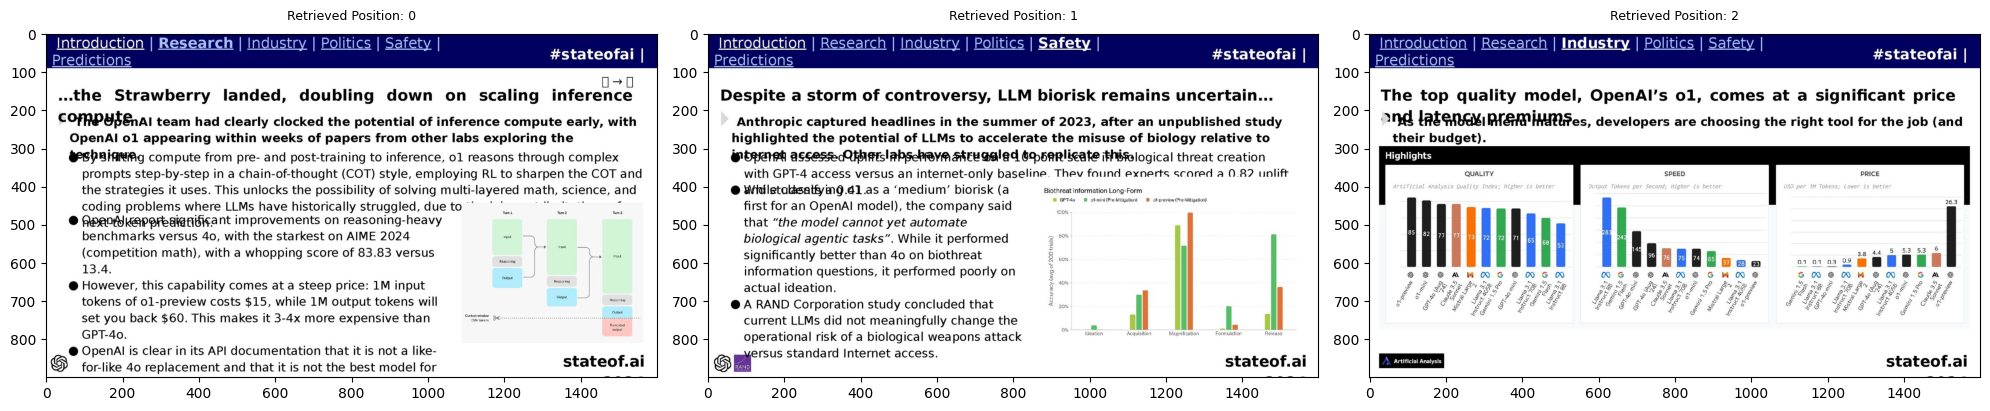

Response: The current capabilities and limitations of OpenAI's o1 model in solving complex mathematical problems are as follows:

### Capabilities:
1. **Inference Compute**: The o1 model shifts compute focus from pre- and post-training to inference, allowing it to reason through complex prompts step-by-step using a chain-of-thought (COT) style.
2. **Improved Reasoning**: It employs reinforcement learning (RL) to enhance its reasoning strategies, enabling it to tackle multi-layered math, science, and coding problems more effectively than previous models.
3. **Benchmark Performance**: The o1 model has shown significant improvements on reasoning-heavy benchmarks, achieving a score of 83.83 on the AIME 2024 competition math, compared to 13.4 for the previous model (4o).

### Limitations:
1. **Cost**: The model is expensive to use, with 1M input tokens costing $15 and 1M output tokens costing $60, making it 3-4 times more expensive than GPT-4o.
2. **Not a Direct Replacement**: OpenAI clarif

In [18]:
from llama_index.core.response.notebook_utils import display_query_and_multimodal_response
from llama_index.core.schema import MetadataMode
from openinference.instrumentation import using_metadata
import os

# Query with contextual retrieval
query = "What are the current capabilities and limitations of OpenAI's o1 model in solving complex mathematical problems?"
contextual_response = contextual_semantic_hybrid_query_engine.query(query)
with using_metadata({"engine": "contextual_semantic_hybrid_query_engine"}):
    result_a = contextual_semantic_hybrid_query_engine.query(query)
    display_query_and_multimodal_response(query, result_a, 8, 20)
    print("\nSource Nodes for contextual_semantic_hybrid_query_engine:")
    for node in result_a.source_nodes:
        print(node.get_content(metadata_mode=MetadataMode.LLM))

In [19]:
def get_source_page_nums(response):
    page_nums = [str(node.node.metadata.get("page_num", "N/A")) for node in response.source_nodes]
    print(",".join(page_nums))

# Compare source page numbers
print("Pages retrieved with standard retreival:")
get_source_page_nums(baseline_response)

print("Pages retrieved with contextual retrieval:")
get_source_page_nums(contextual_response)

Pages retrieved with standard retreival:
14,13,20
Pages retrieved with contextual retrieval:
13,201,108


## Evaluations with Arize Phoenix
### Run Evaluations

In [ ]:
from tqdm import tqdm
import json
from openinference.instrumentation import using_metadata
from phoenix.trace import using_project

# Load all evaluation questions from queries.jsonl
eval_questions = []
with open("eval/contextual-queries-100.jsonl", "r") as file:
    for line in file:
        # Parse each line as JSON and extract the query
        json_line = json.loads(line.strip())
        eval_questions.append(json_line)

# List of query engines and their respective project names
query_engines = [
    (standard_embedding_query_engine, "Standard: Embedding"),
    (standard_hybrid_query_engine, "Standard: Hybrid"),
    (standard_semantic_hybrid_query_engine, "Standard: Hybrid + Rerank"),
    (contextual_embedding_query_engine, "Contextual: Embedding"),
    (contextual_hybrid_query_engine, "Contextual: Hybrid"),
    (contextual_semantic_hybrid_query_engine, "Contextual: Hybrid + Rerank"),
]

# Loop through each question and query it against each engine
for query_data in tqdm(eval_questions):
    query = query_data["query"]
    query_classification = query_data.get("query_classification", "undefined")  # Default to 'undefined' if not present

    for engine, project_name in query_engines:
        try:
            metadata = query_classification
            with using_project(project_name), using_metadata(metadata):
                # Assuming the query method expects a string query and returns results
                engine.query(query)
        except Exception as e:
            print(f"Error querying {project_name} for query '{query}': {e}")


### Export and Evaluate Your Trace Data

In [ ]:
from phoenix.evals import (
    HallucinationEvaluator,
    OpenAIModel,
    QAEvaluator,
    RelevanceEvaluator,
    run_evals,
)
from phoenix.session.evaluation import get_qa_with_reference, get_retrieved_documents
from phoenix.trace import DocumentEvaluations, SpanEvaluations
from tqdm import tqdm

# Define the evaluation model
eval_model = OpenAIModel(
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    azure_deployment="gpt-4o-mini",  # I'm using gpt-4o-mini for evaluation
    model=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    api_version="2024-06-01"
)

# Define evaluators
hallucination_evaluator = HallucinationEvaluator(eval_model)
qa_correctness_evaluator = QAEvaluator(eval_model)
relevance_evaluator = RelevanceEvaluator(eval_model)

# List of project names corresponding to each query engine
projects = [
    "Standard: Embedding",
    "Standard: Hybrid",
    "Standard: Hybrid + Rerank",
    "Contextual: Embedding",
    "Contextual: Hybrid",
    "Contextual: Hybrid + Rerank",
]

# Loop through each project and perform evaluations
for project in projects:
    # Create queries and retrieved documents DataFrames for the project
    queries_df = get_qa_with_reference(px.Client(), project_name=project)
    retrieved_documents_df = get_retrieved_documents(px.Client(), project_name=project)
    
    # Run evaluations
    hallucination_eval_df, qa_correctness_eval_df = run_evals(
        dataframe=queries_df,
        evaluators=[hallucination_evaluator, qa_correctness_evaluator],
        provide_explanation=True,
    )
    relevance_eval_df = run_evals(
        dataframe=retrieved_documents_df,
        evaluators=[relevance_evaluator],
        provide_explanation=True,
    )[0]
    
    # Log evaluations
    px.Client().log_evaluations(
        SpanEvaluations(eval_name=f"Hallucination_{project}", dataframe=hallucination_eval_df),
        SpanEvaluations(eval_name=f"QA Correctness_{project}", dataframe=qa_correctness_eval_df),
        DocumentEvaluations(eval_name=f"Relevance_{project}", dataframe=relevance_eval_df),
    )


### View Evaluation Results in Arize Phoenix UI

**DISCLAIMER**: These evaluations are a quick way to use LLMs to perform evaluations based on a given set of queries (in this case, only 10 random ones). This is not conclusive evidence of retrieval modes but rather a demonstration of a simplified open-source method.

### Query Engine Performance Summary @5

| Retrieval Mode                  | QA Correctness@5 | NDCG@5 | Precision@5 | Hit Rate@5 |
| ------------------------------- | ---------------- | ------ | ----------- | ---------- |
| **Standard: Embedding**          | 1.00             | 0.65   | 0.42        | 0.80       |
| **Standard: Hybrid**             | 0.90             | 0.56   | 0.42        | 0.70       |
| **Standard: Hybrid + Rerank**    | 1.00             | 0.59   | 0.38        | 0.70       |
| **Contextual: Embedding**        | 1.00             | 0.65   | 0.44        | 0.70       |
| **Contextual: Hybrid**           | 1.00             | 0.61   | 0.40        | 0.70       |
| **Contextual: Hybrid + Rerank**  | 1.00             | 0.66   | 0.42        | 0.80       |

### Query Engine Performance Summary @10

| Retrieval Mode                  | QA Correctness@10 | NDCG@10 | Precision@10 | Hit Rate@10 |
| ------------------------------- | ----------------- | ------- | ------------ | ----------- |
| **Standard: Embedding**          | 0.90              | 0.58    | 0.37         | 0.70        |
| **Standard: Hybrid**             | 1.00              | 0.68    | 0.36         | 0.80        |
| **Standard: Hybrid + Rerank**    | 1.00              | 0.58    | 0.34         | 0.70        |
| **Contextual: Embedding**        | 0.90              | 0.63    | 0.42         | 0.70        |
| **Contextual: Hybrid**           | 1.00              | 0.61    | 0.39         | 0.70        |
| **Contextual: Hybrid + Rerank**  | 0.90              | 0.57    | 0.34         | 0.70        |

### Query Engine Performance Summary @20

| Retrieval Mode                  | QA Correctness@20 | NDCG@20 | Precision@20 | Hit Rate@20 |
| ------------------------------- | ----------------- | ------- | ------------ | ----------- |
| **Standard: Embedding**          | 1.00              | 0.59    | 0.33         | 0.80        |
| **Standard: Hybrid**             | 1.00              | 0.62    | 0.31         | 0.80        |
| **Standard: Hybrid + Rerank**    | 1.00              | 0.57    | 0.30         | 0.80        |
| **Contextual: Embedding**        | 0.90              | 0.63    | 0.32         | 0.80        |
| **Contextual: Hybrid**           | 1.00              | 0.63    | 0.32         | 0.80        |
| **Contextual: Hybrid + Rerank**  | 1.00              | 0.59    | 0.29         | 0.80        |


### Key Takeaways:

#### Hypothesis Validation:
The hypothesis that Contextual Hybrid + Rerank should be the best all-around model holds true for relevance (NDCG) but shows some trade-offs in precision and QA correctness at higher cutoffs (@10 and @20).

#### QA Correctness:
- **@5**: Standard Embedding and all Contextual modes achieve 1.00, but Contextual Hybrid + Rerank performs similarly to other Contextual modes.
- **@10 and @20**: Standard Hybrid and Standard Hybrid + Rerank maintain 1.00 at QA Correctness, but Contextual Hybrid + Rerank falls slightly to 0.90 at these larger cutoffs.

#### Relevance (NDCG):
- **@5**: Contextual Hybrid + Rerank achieves the highest score at 0.66, supporting the hypothesis that it excels in relevance.
- **@10 and @20**: Contextual Hybrid + Rerank still performs well but does not consistently outperform Standard Hybrid modes, particularly at @10.

#### Precision:
- **@5**: Contextual Embedding leads with 0.44, with Contextual Hybrid + Rerank close behind, showing that it's strong but not the top performer in precision.
- **@10 and @20**: Precision drops across all models, with Standard Embedding and Contextual Embedding performing best at @20.

#### Hit Rate:
- **@5 and @20**: Standard Embedding and Contextual Hybrid + Rerank maintain a strong and stable hit rate of 0.80, reinforcing their consistency.

---

#### Conclusion:
While Contextual Hybrid + Rerank is strong in relevance (NDCG), particularly at @5, it experiences slight drops in QA Correctness and Precision at higher cutoffs. Standard Embedding and Standard Hybrid provide more consistent performance across all metrics, making Contextual Hybrid + Rerank the best for relevance but not necessarily the best all-around model in terms of precision and correctness.

##### Why Were These Results Seen?:
- Contextual Hybrid + Rerank excels at relevance (NDCG) because it effectively integrates both semantic and lexical retrieval while incorporating additional reranking capabilities. However, precision and QA correctness are more influenced by the specifics of how queries map to document content. Reranking models can occasionally emphasize relevance over exactness, which might explain the slight reduction in QA Correctness at higher cutoffs.

- The Standard Embedding and Standard Hybrid modes, which rely more on pure embeddings or hybrid retrieval without reranking, maintain high QA Correctness due to their consistency in retrieving relevant results across multiple document segments without as much reranking intervention.

- Hit Rate: Across all models, the Hit Rate remains stable at 0.80, likely due to the effectiveness of hybrid models that combine embeddings and lexical matching. This balance helps ensure relevant chunks of documents are consistently retrieved.

- Fewer Queries for Validation: Note that the experiment was conducted with only 10 queries of diverse classification types, which may not represent a real production scenario. More queries would provide a more robust sample and further validate these results.

---

#### Next Steps:
- Increase Query Size for Testing: Perform evaluations on at least 100–1000 queries to ensure the validation is more representative of real-world production scenarios. This will also give more clarity on the performance drop seen at higher cutoffs.

- Refine LLM Judge: While the LLM Judge was used effectively in this experiment, using a labeled dataset for evaluation could enhance the validity of QA Correctness results. Relying on an LLM to judge queries works well for quick iterations but may not capture edge cases where human oversight or predefined labels would perform better.

- Adjust Reranking Models: Fine-tuning the reranking algorithms in the Contextual Hybrid + Rerank mode could help balance relevance and precision, especially at higher cutoffs. Adjusting weightings between lexical and semantic retrieval might also improve overall performance.

- Examine Variability in Model Behavior: Investigate how model performance varies by query complexity, type, and length. Certain models may perform better with different document formats or query styles (e.g., complex technical documents vs. shorter, more straightforward queries).

- Expand Observations: Observations from this notebook were generally consistent, with the QA Correctness model performing accurately in terms of its justification. However, this should be tested further with more granular evaluations and comparisons to a human-labeled dataset.


To learn more about the Arize Phoenix Evaluators using LLM as a Judge, please see here: [Arize Phoenix Evaluators](https://docs.arize.com/phoenix/evaluation/concepts-evals/evaluation)